# Stanford dogs: breed classifier

## 1. Import libraries and define data folders

In [1]:
# files loading
import os

from random import shuffle
import numpy as np

from tqdm import tqdm # progress bar

In [2]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [3]:
# libraries for a CNN
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
#horizontal flip image augmentation libraries

from tensorflow import keras
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [5]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
# 

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [7]:
ANNOTATION_DIR = '../input/stanford-dogs-dataset/annotations/Annotation' 
IMAGES_DIR = '../input/stanford-dogs-dataset/images/Images'

### 1.1 Visualize list of breeds (classes) and a sample data (image)

In [8]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [9]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:10]

['Weimaraner',
 'affenpinscher',
 'Chesapeake_Bay_retriever',
 'Sussex_spaniel',
 'Leonberg',
 'Maltese_dog',
 'Saluki',
 'kelpie',
 'keeshond',
 'American_Staffordshire_terrier']

## 1.2 Example equalization 

n02106166-Border_collie


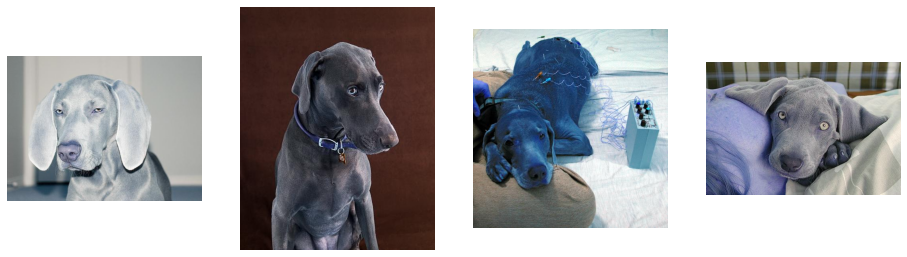

In [10]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[11])
show_dir_images(breed_list[0], 4)



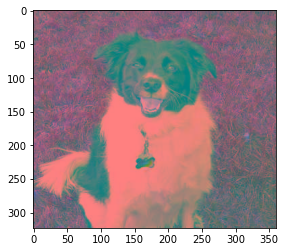

In [11]:
img_dir = "../input/stanford-dogs-dataset/images/Images/{}/".format(breed_list[11])
images = os.listdir(img_dir)[:12]
images = os.listdir(img_dir)[:4]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)


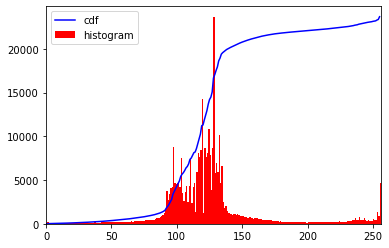

In [12]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

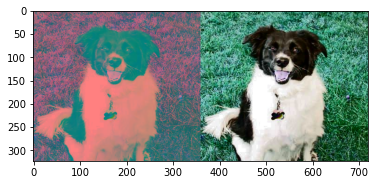

In [13]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

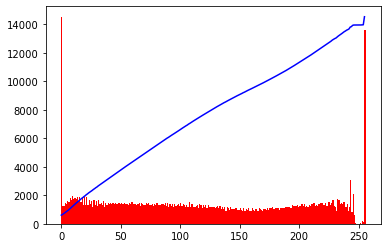

In [14]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

## 1.3 Example augmentations: mirroring and rotation

Augmented by rotation:


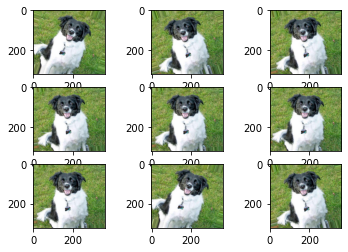

<Figure size 720x720 with 0 Axes>

In [15]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

## 1.4 Batch processing - equalization and augmentation

In [16]:
num_breeds = 15 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2556 
No. of labels loaded =  2556
<class 'list'> <class 'list'>


In [17]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2556, 227, 227, 3) 
Labels shape =  (2556,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 2. Prepare data for training the CNN model

- For training the CNN model we have to shuffle all the data that is loaded in images, labels list.

### 2.1 data shuffling

In [18]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [1266 1749 2050  393 1544  478 2401 1465 1231 1149]


In [19]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (2556, 227, 227, 3) 
Labels shape after shuffling =  (2556,)
same shapes before and after shuffling


### 2.2 data normalization

In [20]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255


### 2.3 test, validation and train sets 

In [21]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1839, 227, 227, 3)
y_train shape =  (1839,)

x_val shape =  (205, 227, 227, 3)
y_val shape =  (205,)

x_test shape =  (512, 227, 227, 3)
y_test shape =  (512,)


### 2.4 augment the training data

In [22]:

datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train, augment=True)


## 3. First CNN model

### 3.1 define layers

In [23]:
## inspired from http://machinememos.com/python/keras/artificial%20intelligence/machine%20learning/transfer%20learning/dog%20breed/neural%20networks/convolutional%20neural%20network/tensorflow/image%20classification/imagenet/2017/07/11/dog-breed-image-classification.html


model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(227, 227, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(133, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 227, 227, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 227, 227, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 32)        9

### 3.2 Compile the CNN model

In [24]:

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0015)

### 3.3 Fit the model using training data

In [25]:
%%time
history =model.fit(x_train, y_train, epochs=10)


Epoch 1/10
58/58 [==============================] - 1s 23ms/step - loss: 2.8977 - accuracy: 0.1550
Epoch 2/10
58/58 [==============================] - 1s 22ms/step - loss: 2.2755 - accuracy: 0.2675
Epoch 3/10
58/58 [==============================] - 1s 22ms/step - loss: 2.0445 - accuracy: 0.3187
Epoch 4/10
58/58 [==============================] - 1s 21ms/step - loss: 1.9542 - accuracy: 0.3632
Epoch 5/10
58/58 [==============================] - 1s 23ms/step - loss: 1.8634 - accuracy: 0.4035
Epoch 6/10
58/58 [==============================] - 1s 21ms/step - loss: 1.7663 - accuracy: 0.4269
Epoch 7/10
58/58 [==============================] - 1s 22ms/step - loss: 1.6759 - accuracy: 0.4475
Epoch 8/10
58/58 [==============================] - 1s 23ms/step - loss: 1.5690 - accuracy: 0.4943
Epoch 9/10
58/58 [==============================] - 1s 22ms/step - loss: 1.4989 - accuracy: 0.5014
Epoch 10/10
58/58 [==============================] - 1s 21ms/step - loss: 1.4244 - accuracy: 0.5443
CPU times

In [26]:
loss, accuracy = model.evaluate(x_test, y_test)

print(loss,accuracy)

16/16 [==============================] - 0s 12ms/step - loss: 2.1941 - accuracy: 0.3242
2.194075107574463 0.32421875


## 4. AlexNet

### 4.1 define layers

In [27]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))



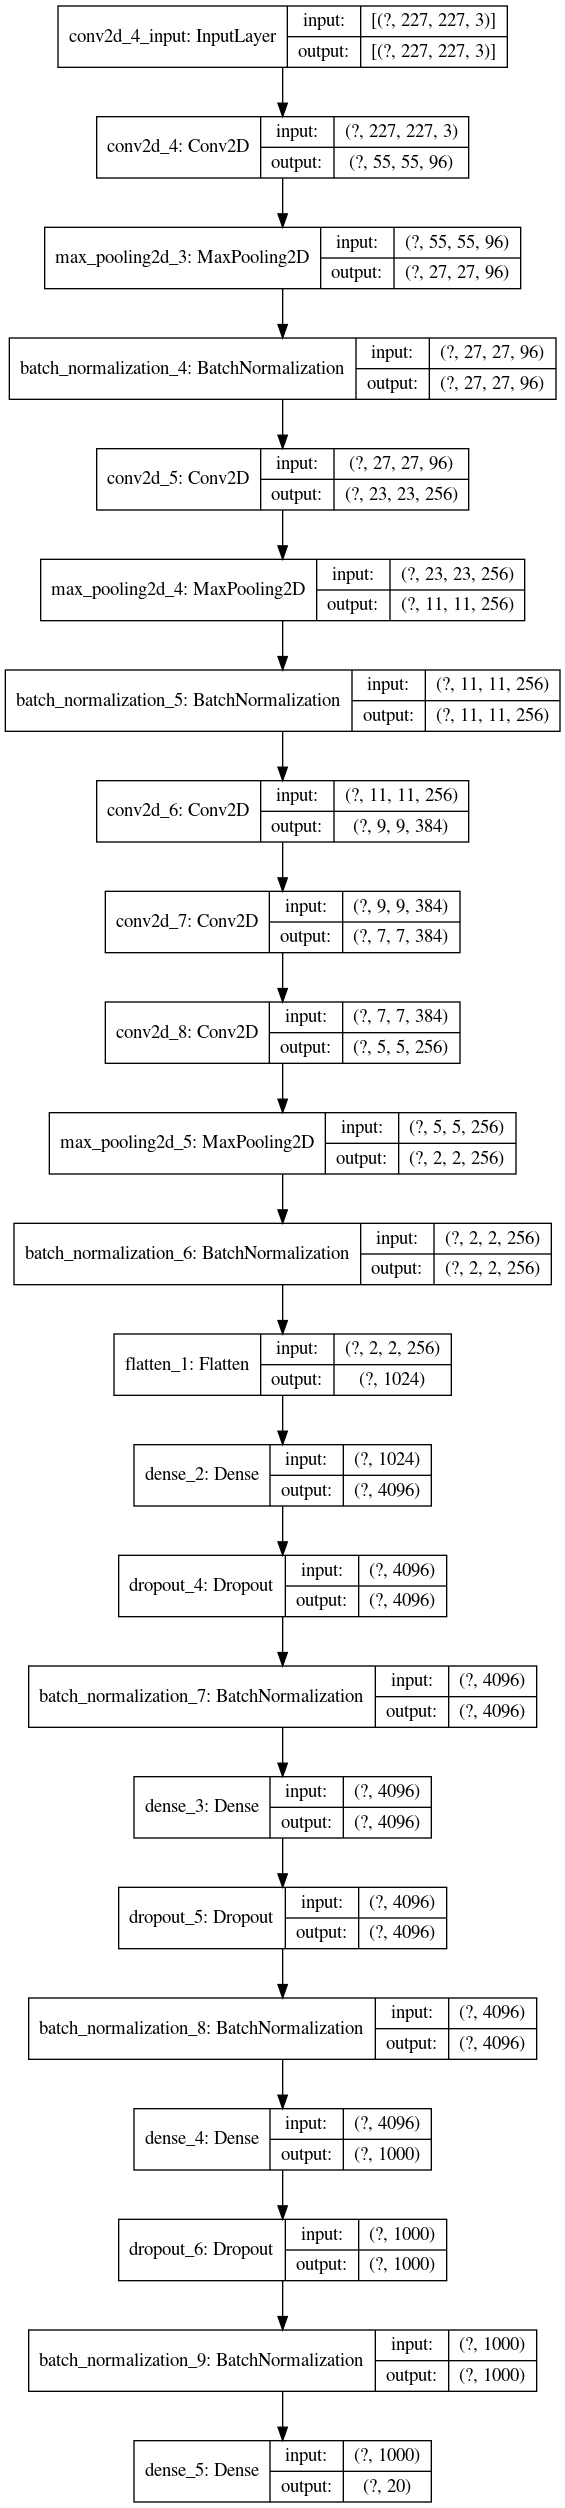

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 4.2 compile and run

In [29]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [30]:
%%time
#with tf.device('/device:GPU:0'):
    #history = model.fit(aug.flow(x_train, y_train), validation_data=(x_val, y_val), epochs=30)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
58/58 [==============================] - 2s 37ms/step - loss: 3.2878 - accuracy: 0.1332 - val_loss: 14.0221 - val_accuracy: 0.0537
Epoch 2/100
58/58 [==============================] - 2s 30ms/step - loss: 2.7719 - accuracy: 0.1914 - val_loss: 3.5319 - val_accuracy: 0.1171
Epoch 3/100
58/58 [==============================] - 2s 30ms/step - loss: 2.6513 - accuracy: 0.2164 - val_loss: 3.7539 - val_accuracy: 0.1073
Epoch 4/100
58/58 [==============================] - 2s 30ms/step - loss: 2.5281 - accuracy: 0.2213 - val_loss: 2.8841 - val_accuracy: 0.1951
Epoch 5/100
58/58 [==============================] - 2s 35ms/step - loss: 2.4330 - accuracy: 0.2490 - val_loss: 3.7660 - val_accuracy: 0.1366
Epoch 6/100
58/58 [==============================] - 2s 32ms/step - loss: 2.4499 - accuracy: 0.2577 - val_loss: 3.2014 - val_accuracy: 0.1561
Epoch 7/100
58/58 [==============================] - 2s 30ms/step - loss: 2.3153 - accuracy: 0.2828 - val_loss: 2.6218 - val_accuracy: 0.2195
Epoch

In [31]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

16/16 [==============================] - 0s 14ms/step - loss: 5.7139 - accuracy: 0.3066
5.713887691497803 0.306640625


In [32]:
pred = model.predict(x_test)

pred.shape

(512, 20)

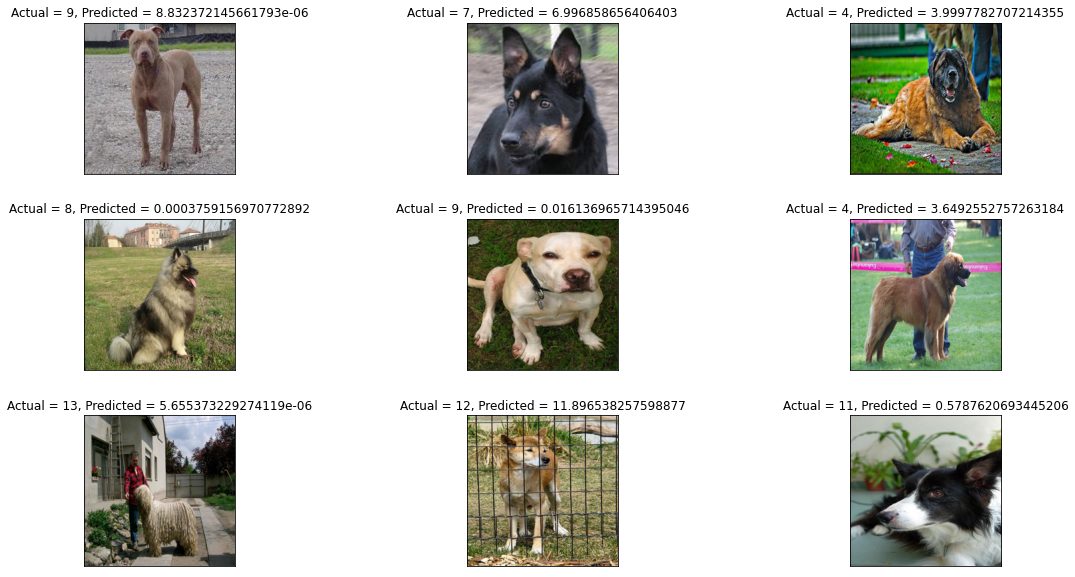

In [33]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()